In [1]:
%matplotlib inline

In [2]:
import json
import math
import os
import random
import time
from collections import Counter, namedtuple
from itertools import count
from typing import Dict, Optional
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from env import GameEnv

In [3]:
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    
    def __len__(self):
        return len(self.rewards)
  

In [4]:
class Actor(nn.Module):
    def __init__(self, input_shape, outputs):
        super().__init__()

        self.outputs = outputs
        self.fn1 = nn.Linear(input_shape, 300)
        self.fn2 = nn.Linear(300, 300)
        self.fn3 = nn.Linear(300, 200)
        self.fn4 = nn.Linear(200, 200)
        self.fn5 = nn.Linear(200, 100)
        self.fn6 = nn.Linear(100, 100)

        self.head = nn.Linear(100, outputs)


    def forward(self, x):
        x = F.relu(self.fn1(x.view(x.size(0), -1)))
        x = F.relu(self.fn2(x))
        x = F.relu(self.fn3(x))
        x = F.relu(self.fn4(x))
        x = F.relu(self.fn5(x))
        x = F.relu(self.fn6(x))

        return F.softmax(self.head(x), dim=1)

class Critic(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.fn1 = nn.Linear(input_shape, 300)
        self.fn2 = nn.Linear(300, 300)
        self.fn3 = nn.Linear(300, 200)
        self.fn4 = nn.Linear(200, 200)
        self.fn5 = nn.Linear(200, 100)
        self.fn6 = nn.Linear(100, 100)

        self.head = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fn1(x.view(x.size(0), -1)))
        x = F.relu(self.fn2(x))
        x = F.relu(self.fn3(x))
        x = F.relu(self.fn4(x))
        x = F.relu(self.fn5(x))
        x = F.relu(self.fn6(x))

        return self.head(x)

In [32]:
  def optimize_model(q_val):
        values = torch.stack(memory.values)
        q_vals = np.zeros((len(memory), 1))

        # target values are calculated backward
        # it's super important to handle correctly done states,
        # for those cases we want our to target to be equal to the reward only
        q_val = q_val.item()
        for i, (_, _, reward, done) in enumerate(memory.reversed()):
            q_val = reward + GAMMA*q_val*(1.0-done)
            # store values from the end to the beginning
            q_vals[len(memory)-1 - i] = q_val

        advantage = torch.Tensor(q_vals).to(device) - values

        critic_loss = advantage.pow(2).mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        actor_loss = (-torch.stack(memory.log_probs)
                      * advantage.detach()).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

In [1]:
def train(num_episodes):
    max_steps = 2000
    global max_steps_count
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        steps = 0

        current_board = get_state()
        for t in count():
            probs = actor(current_board)
            dist = torch.distributions.Categorical(probs=probs)
            action = dist.sample()

            _, reward, done, _ = env.step(action.item())
            steps += 1
            memory.add(dist.log_prob(action), critic(current_board), reward, done)
            current_board = get_state()

            if done or (steps % max_steps == 0):
                if (steps % max_steps == 0):
                    print("max steps reached")
                    max_steps_count +=1

                last_q_val = critic(current_board)
                optimize_model(last_q_val)
                memory.clear()
                episode_scores.append(env.score)
                highest_scores.append(env.highest())
                plot_scores()
                break
        if max_steps_count > 2000:
            break

    env.close()

In [9]:
def plot_scores(save=None):
    plt.figure(2)
    plt.clf()
    scores_t = torch.tensor(highest_scores, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Highest Scores')
    plt.plot(scores_t.numpy())
    # Take 100 episode averages and plot them too
    if len(scores_t) >= 100:
        means = scores_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

    plt.pause(0.001)  # pause a bit so that plots are updated

    display.clear_output(wait=True)

In [10]:
def write_results(log_dir):
    try:
        os.makedirs(log_dir)
    except OSError:
        pass
    plot_scores(save=f"{log_dir}/plot.png")
    torch.save(actor, f"{log_dir}/actor.pt")
    torch.save(critic, f"{log_dir}/critic.pt")
    torch.save(actor_optimizer, f"{log_dir}/actor_optimizer.pt")
    torch.save(critic_optimizer, f"{log_dir}/critic_optimizer.pt")

    with open(f"{log_dir}/highest_scores.json", "w") as json_file:
        scores = {str(k): v for k, v in Counter(
            highest_scores).items()}
        print(scores)
        json.dump(scores, json_file)

In [30]:
def evaluate(steps):
    episode_scores = []
    highest_scores = []
    for i in range(steps):
        env.reset()
        steps_done = 0
        for t in count():
            probs = actor(get_state(env))
            dist = torch.distributions.Categorical(probs=probs)
            action = dist.sample()
            board, reward, done, info = env.step(action.item())
            steps_done += 1
            if done or steps_done > 2000:
                if steps_done > 2000:
                    print("max steps reached")
                env.render()
                episode_scores.append(env.score)
                highest_scores.append(env.highest())
                break
    print(Counter(highest_scores))
    plt.plot(highest_scores)

In [11]:
num_episodes = 1000
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1.
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
MEMORY_SIZE = 10000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Start training setup

In [13]:
# 4*16 matrix
def get_state(env: GameEnv):
    with np.errstate(divide='ignore'):
        board = np.where(env.board != 0, np.log2(env.board).astype(np.int), 0)
    board = np.vectorize(np.binary_repr)(board, width=4).astype(str)
    board = np.array([list(''.join(line)) for line in board]).astype(np.int)
    return torch.from_numpy(np.ascontiguousarray(board)).unsqueeze(0).float().to(device)

In [14]:
class Reward1():
    @staticmethod
    def reward_function(score) -> float:
        return score / 80
    
    @staticmethod
    def tile_merge_reward(value_pair) -> float:
        return np.log2(value_pair[0])

    @staticmethod
    def final_state_reward(score: float = None) -> float:
        return 0.

    @staticmethod
    def invalid_move_reward() -> float:
        return 0.

env = GameEnv(reward_class=Reward1)

In [15]:
episode_scores = []
highest_scores = []
memory = Memory()
steps_done = 0
n_actions = env.action_space.n
actor = Actor(4*16, n_actions).to(device)
critic = Critic(4*16).to(device)
actor_optimizer = optim.RMSprop(actor.parameters())
critic_optimizer = optim.RMSprop(critic.parameters())
max_steps_count = 0

In [16]:
import logging
logging.basicConfig(level=logging.DEBUG, filename="run.log")

In [33]:
for i in range(10):
    train(num_episodes)
    write_results(f"runs/a2c1/{i}")

torch.Size([996])
torch.Size([997])
torch.Size([996])
torch.Size([998])
torch.Size([995])
torch.Size([996])
torch.Size([993])
torch.Size([995])


KeyboardInterrupt: 

Score: 2.2999999999999994
Highest: 128
[[  4   2   4   2]
 [ 16   4   8   4]
 [  2  16  32  16]
 [  8   4 128   2]]
Score: 2.6125000000000003
Highest: 128
[[  2   4  16   4]
 [  4  16 128   2]
 [ 16   4  64   8]
 [  2   8   4   2]]
Score: 1.587499999999999
Highest: 64
[[ 2  8  4  2]
 [ 8 16 64  8]
 [16  8  2 32]
 [ 4 16  4  2]]
Score: 1.3750000000000002
Highest: 64
[[ 4  2 64  2]
 [ 2  4  2  8]
 [ 4 32  4  2]
 [ 2  4 32  4]]
Score: 2.4500000000000006
Highest: 128
[[  4   2   4   2]
 [  2   4 128   4]
 [ 16   8  64   8]
 [  4  16   2   4]]
Score: 5.150000000000002
Highest: 256
[[  2   8  64   2]
 [  8  32 256   4]
 [  2  64   4  16]
 [  4   2  32   2]]
Score: 1.5874999999999997
Highest: 64
[[ 4  2  4  8]
 [ 2  8 16  2]
 [ 4 16  8 64]
 [ 2  8 32 16]]
Score: 1.5499999999999994
Highest: 64
[[ 2  4 16  8]
 [ 4 32  4  2]
 [16 64  8  4]
 [ 2  8  2 16]]
Score: 1.637499999999999
Highest: 64
[[ 2  4  2  8]
 [ 4 64 16  2]
 [16  8 32  4]
 [ 4 16  4 16]]
Score: 2.275000000000001
Highest: 64
[[ 2  4

Score: 1.2249999999999992
Highest: 64
[[ 4  2  8  2]
 [ 2  4  2  8]
 [ 8 32  4  2]
 [ 2 64  8  4]]
Score: 2.099999999999999
Highest: 128
[[  4   8   2   4]
 [  2  16   4  32]
 [  4   8   2   4]
 [  2  16 128   2]]
Score: 3.0500000000000007
Highest: 128
[[  4  16   4   2]
 [  8  32  16   4]
 [ 16   2 128  16]
 [  8  64   4   2]]
Score: 2.8
Highest: 128
[[  2   4   8   2]
 [  4   8   2   8]
 [ 16  32   8  64]
 [  2   4 128   4]]
Score: 2.1375
Highest: 64
[[ 4  8  4  2]
 [ 8 32 16  8]
 [16  4 64  2]
 [ 2 64  2 16]]
Score: 3.8750000000000027
Highest: 128
[[  8   4  16   2]
 [ 64 128  64   4]
 [  4  16   2  16]
 [ 32   2  32   4]]
Score: 3.1375000000000015
Highest: 128
[[  2   4  32   8]
 [  4   8  16   2]
 [  8  64 128  16]
 [  4   2  32   2]]
Score: 3.2375000000000003
Highest: 128
[[  2   8   4   2]
 [ 64   2  16   8]
 [  4   8 128  16]
 [  8   4  64   2]]
Score: 1.962499999999999
Highest: 64
[[ 2  4  8  2]
 [16  8 16  4]
 [32 64 32 16]
 [ 8 16  4  2]]
Score: 2.5749999999999997
Highest: 6

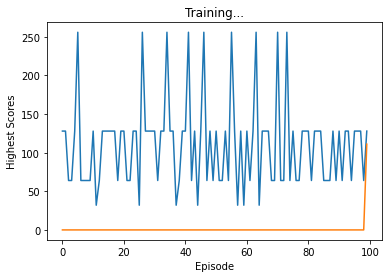

In [31]:
evaluate(100)

In [ ]:
class Reward2():
    @staticmethod
    def reward_function(score) -> float:
        return min(score/4, 1)
    
#     number of tiles mergesd
    @staticmethod
    def tile_merge_reward(value_pair) -> float:
        return 1

    @staticmethod
    def final_state_reward(score: float = None) -> float:
        return -1.

    @staticmethod
    def invalid_move_reward() -> float:
        return 0.

env = GameEnv(reward_class=Reward2)

In [20]:
episode_scores = []
highest_scores = []
memory = Memory()
steps_done = 0
n_actions = env.action_space.n
actor = Actor(4*16, n_actions).to(device)
critic = Critic(4*16).to(device)
actor_optimizer = optim.RMSprop(actor.parameters())
critic_optimizer = optim.RMSprop(critic.parameters())
max_steps_count = 0

In [ ]:
for i in range(10):
    train(num_episodes)
    write_results(f"runs/a2c2/{i}")

In [ ]:
evaluate(100)

In [19]:
# 4*4 matrix
def get_state(env: GameEnv):
    with np.errstate(divide='ignore'):
        board = np.where(env.board != 0, np.log2(env.board), 0)
        return torch.from_numpy(np.ascontiguousarray(board)).unsqueeze(0).float().to(device)

In [23]:
# def state2tensor(state):
#     t = np.zeros((16, 16), dtype=np.float32)
#     for i, c in enumerate(state.flatten()):
#         t[c, i] = 1
#     t.resize(1, 16, 4, 4)
#     return t